In [79]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import quaternion
import pyquaternion

In [4]:
data_dir='/scratch/jaidev/Adrian/0/front'

In [5]:
os.listdir(data_dir)

['pose', 'DEPTH', 'RGB', 'map']

In [48]:
idx1 = 155
idx2 = 160

rgb1 = cv2.cvtColor(cv2.imread(os.path.join(data_dir, 'RGB', f'{idx1}.jpg'), -1), cv2.COLOR_BGR2RGB)
rgb2 = cv2.cvtColor(cv2.imread(os.path.join(data_dir, 'RGB', f'{idx2}.jpg'), -1), cv2.COLOR_BGR2RGB)

pose1 = np.load(os.path.join(data_dir, 'pose', f'{idx1}.npy'), allow_pickle=True)
pose2 = np.load(os.path.join(data_dir, 'pose', f'{idx2}.npy'), allow_pickle=True)

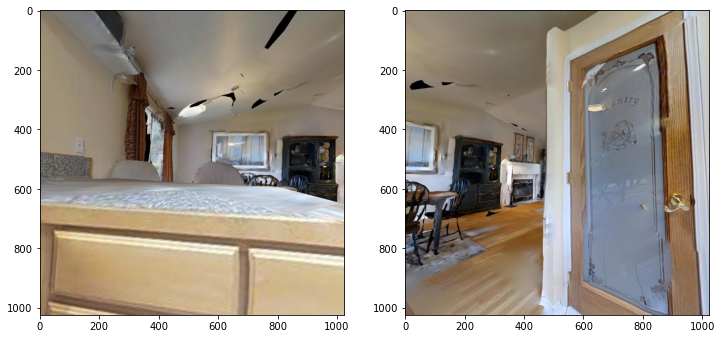

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(rgb1)
ax[1].imshow(rgb2)

In [126]:
# print(pose1.item()['rotation'], pose2.item()['rotation'])

# r1 = quaternion.as_rotation_vector(pose1.item()['rotation'])
# r2 = quaternion.as_rotation_vector(pose2.item()['rotation'])

r1 = quaternion.from_float_array([0.679549217224121, -0, -0.733629941940308, -0])
r2 = quaternion.from_float_array([0.666843116283417, 0, 0.745198130607605, 0])

r1 = quaternion.as_rotation_vector(r1)
r2 = quaternion.as_rotation_vector(r2)

print(r1, r2)

vertical = np.array([0, 1, 0], dtype=np.float64)
r1_ = np.dot(r1, vertical) * vertical
r2_ = np.dot(r2, vertical) * vertical

rot_angle = np.dot(r2, vertical) - np.dot(r1, vertical)
complement_angle = (np.pi*2 - np.abs(rot_angle)) * -np.sign(rot_angle)

print(np.rad2deg(rot_angle), np.rad2deg(complement_angle))
print(rot_angle, complement_angle)

rot_angle = rot_angle if np.abs(rot_angle) < np.abs(complement_angle) else complement_angle
# rot_angle *= -1
print(np.rad2deg(rot_angle))

angle_thresh = np.pi/6
rot_inc = np.arange(0, rot_angle, angle_thresh * np.sign(rot_angle))

if not np.isclose(rot_inc[-1] - rot_angle, 0, atol=1e-3):
    rot_inc = np.concatenate([rot_inc, [rot_angle]])
    
print(rot_inc)

rot_val = (rot_inc + np.dot(r1, vertical)) % (np.pi*2)

print(np.array(list(map(lambda x: x * vertical, rot_val))))

print("\n", quaternion.from_rotation_vector(rot_val[-1] * vertical))

# quat_inc = list(map(lambda x: quaternion.from_rotation_vector(x * vertical), rot_val))
# print(quat_inc)


[ 0.         -1.64729667  0.        ] [0.         1.68166382 0.        ]
190.73538658517757 -169.26461341482243
3.328960495975572 -2.954224811204014
-169.26461341482243
[ 0.         -0.52359878 -1.04719755 -1.57079633 -2.0943951  -2.61799388
 -2.95422481]
[[0.         4.63588863 0.        ]
 [0.         4.11228986 0.        ]
 [0.         3.58869108 0.        ]
 [0.         3.06509231 0.        ]
 [0.         2.54149353 0.        ]
 [0.         2.01789476 0.        ]
 [0.         1.68166382 0.        ]]

 quaternion(0.666843117751923, 0, 0.745198132248663, 0)


In [128]:
4.63588863 - (np.pi*2)

-1.647296677179586

In [120]:
(1.68 + 1.64), np.pi

(3.32, 3.141592653589793)

In [67]:
# rot_angle = np.linalg.norm(r2_, ord=2) - np.linalg.norm(r1_, ord=1) 
# complement_angle = (np.pi*2 - np.abs(rot_angle)) * -np.sign(rot_angle)

# rot_angle = rot_angle if np.abs(rot_angle) < np.abs(complement_angle) else complement_angle
# print(rot_angle)

# angle_thresh = np.pi/6
# rot_inc = np.arange(0, rot_angle, angle_thresh * np.sign(rot_angle))

# rot_val = rot_inc + np.linalg.norm(r1_, ord=1) 

# rot_vecs = list(map(lambda x: quaternion.from_rotation_vector(x * vertical), rot_val))
# print(rot_vecs)

# # if rot_inc[-1] - rot_angle

-1.0539095
[quaternion(0.671500625109109, 0, 0.741003988166106, 0), quaternion(0.840405744744741, 0, 0.541957732853805, 0), quaternion(0.952038598542913, 0, 0.305977951631233, 0)]


 # Rotation about each axis 

In [15]:
rot_axis = []

filenames = sorted(os.listdir(os.path.join(data_dir, 'pose')), key=lambda k: int(os.path.splitext(k)[0]))

old_q = np.load(os.path.join(data_dir, 'pose', filenames[0]), allow_pickle=True).item()['rotation']

for filename in filenames[1:]:
    pose = np.load(os.path.join(data_dir, 'pose', filename), allow_pickle=True)
    new_q = pose.item()['rotation']
    
    angle_diff = new_q.conjugate() * old_q
    rot_axis.append(quaternion.as_rotation_vector(angle_diff))
    old_q = new_q

In [16]:
rot_axis = np.array(rot_axis)# * 180/np.pi
rot_axis[np.abs(rot_axis[:, 1]) > 5] = 0
rot_axis.shape

(207, 3)

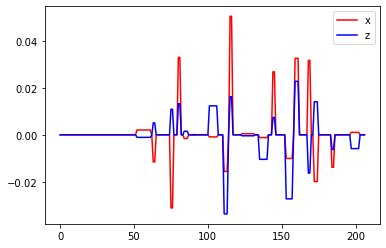

In [17]:
plt.plot(np.arange(rot_axis.shape[0]), rot_axis[:, 0], 'r', label='x')
# plt.plot(np.arange(rot_axis.shape[0]), rot_axis[:, 1], 'g', label='y')
plt.plot(np.arange(rot_axis.shape[0]), rot_axis[:, 2], 'b', label='z')

plt.legend()

In [88]:
def pyquaternion_to_quaternion(quat):
    return np.quaternion(quat.scalar, *quat.vector)

In [116]:
r1 = quaternion.from_float_array([0.679549217224121, -0, -0.733629941940308, -0])
r2 = quaternion.from_float_array([0.666843116283417, 0, 0.745198130607605, 0])

q1 = pyquaternion.Quaternion(r1.w, r1.x, r1.y, r1.z)
q2 = pyquaternion.Quaternion(r2.w, r2.x, r2.y, r2.z)

q12 = q1.conjugate * q2

max_sep = 30 #np.pi/6

diff = 2 * np.arccos(q12.scalar)
print(np.rad2deg(diff))

num_intermediates = (diff * 180 / np.pi) // max_sep
print(num_intermediates)

if num_intermediates == 0:
    pass

intermediate_py_quat = list(pyquaternion.Quaternion.intermediates(q1, q2, int(num_intermediates), include_endpoints=True))[1:] #Exclude current orientation, but include last

intermediate_np_quat = list(map(pyquaternion_to_quaternion, intermediate_py_quat)) # Convert to numpy quaternion form

for i in range(len(intermediate_np_quat)):
    print(quaternion.as_rotation_vector(intermediate_np_quat[i]), end=" ")

print("\n", intermediate_np_quat[-1])

190.73538672480763
6.0
[0.         4.21385652 0.        ] [0.        3.7918244 0.       ] [0.         3.36979229 0.        ] [0.         2.94776017 0.        ] [0.         2.52572805 0.        ] [0.         2.10369594 0.        ] [0.         1.68166382 0.        ] 
 quaternion(0.666843117751923, 0, 0.745198132248662, 0)


[[0.0000000e+00 4.9171605e-05 0.0000000e+00]
 [0.0000000e+00 5.2364796e-01 0.0000000e+00]
 [0.0000000e+00 1.0472467e+00 0.0000000e+00]
 [0.0000000e+00 1.5708455e+00 0.0000000e+00]]

In [103]:
np.pi/6

0.5235987755982988